## Example of GWR

### Goal
- Estimate spatially varying relationships (GWR) of corn yield to N and seeding rates.
- To do so, we are going to use different a spatial dataset from DIFM project’s which is already tidied and stored in the geopackage format ( field05.gpkg ).

### Dataset
- GeoPackage: `Field05.gpkg`
- Path: `Enter/your/directory`

You can download the data file and upload here- if `wget` command doesn't work below

[https://github.com/acesillinois/cpsc444-F2025/blob/main/datasets/Field05.gpkg](https://)

### Requirements
Install packages if needed (uncomment and run in a terminal or a notebook cell):
```bash
pip install geopandas pyproj shapely rtree statsmodels seaborn matplotlib pandas numpy scikit-gstat mgwr contextily
```


These data are from a on-farm experiments conducted in commercial fields using precision agriculture machinery and sensors in order to apply treatments and collect crop response. Thus, N rate and seeding Rate treatments were applied to the whole field using VRT enabled planter following a fully randomized chessboard design as a prescription map. Then, the crop response, i.e. yield, was measured using yield monitors mounted on harverster combines.



In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-gstat mgwr

!wget https://github.com/acesillinois/cpsc444-F2025/raw/refs/heads/main/datasets/Field05.gpkg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.6/708.6 kB 19.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [mgwr]
--2025-10-23 14:28:29--  https://github.com/acesillinois/cpsc444-F2025/raw/refs/heads/main/datasets/Field05.gpkg
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Field05.gpkg [following]
--2025-10-23 14:28:29--  https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Field05.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, .

In [ ]:
!pip install geopandas pyproj shapely rtree statsmodels seaborn matplotlib pandas numpy scikit-gstat mgwr contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 146.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [contextily]


In [ ]:
# Imports and setup
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / models
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Variogram
from skgstat import Variogram

# GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Mapping
import contextily as cx

# Plot style
sns.set(style="whitegrid", context="notebook")
plt.rcParams.update({"figure.figsize": (8, 6), "figure.dpi": 120})

# Paths
GPKG_PATH = "Field05.gpkg"

print("GeoPackage path exists:", os.path.exists(GPKG_PATH))

GeoPackage path exists: True


In [ ]:
field05 = gpd.read_file("Field05.gpkg")
field05.head()

,SubID,ID,SRPlan,NPlan,Area,Headland,N_pts,MuKey,ECS_sd,ECS,...,VI1,VI2_sd,VI2,VI3_sd,VI3,SRPlan2,NPlan2,NPlanf,SRPlanf,geometry
0,39,24,31000.0,44.0,1560.298728,No,16,246517,0.546958,20.442388,...,-0.025056,0.005544,-0.078950,0.008520,-0.004986,9.610000e+08,1936.0,44,31k,"POLYGON ((364080.179 4398372.82, 364101.508 43..."
1,40,24,31000.0,44.0,1560.298728,No,15,246517,0.772253,22.111250,...,-0.009737,0.007371,-0.084663,0.006777,0.004405,9.610000e+08,1936.0,44,31k,"POLYGON ((364101.509 4398372.447, 364122.838 4..."
2,41,25,34500.0,38.0,1560.297979,No,15,246544,0.718886,23.301075,...,-0.014970,0.008884,-0.097565,0.005224,-0.001865,1.190250e+09,1444.0,38,34k,"POLYGON ((364122.838 4398372.074, 364144.167 4..."
3,42,25,34500.0,38.0,1560.297979,No,16,246544,0.755857,22.708853,...,-0.039440,0.017035,-0.081638,0.003575,0.003028,1.190250e+09,1444.0,38,34k,"POLYGON ((364144.168 4398371.701, 364165.497 4..."
4,43,25,34500.0,38.0,1560.297979,No,14,246544,0.322303,21.599925,...,-0.098559,0.018276,-0.026506,0.012072,-0.006675,1.190250e+09,1444.0,38,34k,"POLYGON ((364165.497 4398371.328, 364186.826 4..."



The object `field05` is a `multipolygon` containing 823 features. Each feature is a square polygon of 1560 m^2^ resulted from the data aggregation process as the sources of spatial data were in differente models (raster, vector) with different resolutions.

Each feature has the following attributes:

- `SubID`: feature identifier
- `ID`: experimental plot identifier
- `SRPlan`: seeding Rates values as prescripted in the experimental design
- `NPlan`: nitrogen rate values as prescripted in the experimental design
- `Area`: surface area of each feature (in m^2^)
- `Headland`: indicator variable weather the feature is located within headland
- `N_pts`: number of points aggregated
- `MuKey`: map unit key from SSURGO
- `ECS` and `ECS_sd`: average and standard deviation of the EC shallow values within the feature.
- `ECD` and `ECD_sd`: average and standard deviation of the EC deep values within the feature.
- `Elev` and `Elev_sd`: average and standard deviation of the elevation values within the feature as obtained from DEM.
- `Slope` and `Slope_sd`: average and standard deviation of the slope values within the feature values as derived from DEM.
- `Curv` and `Curv_sd`: average and standard deviation of the curvature values within the feature as derived from DEM.
- `TWI` and `TWI_sd`: average and standard deviation of the topographic wetness index (TWI) values within the feature as derived from DEM.        
- `TPI` and `TPI_sd`: average and standard deviation of the topographic position index (TWI) values within the feature as derived from DEM.
- `Yield` and `Yield_sd`: average and standard deviation of the yield estimates within the feature.
- `Moisture` and `Moisture_sd`: average and standard deviation of the moisture values within the feature.   
- `VI{1,2,3}` and `VI{1,2,3}_sd`: average and standard deviation of vegetation indices within the feature.   
- `SRPlan2` and `NRPlan2`: squared seed and N rates values
- `SRPlanf` and `NPlanf`: seed and N rates converted to factor.

The following plots show the actual spatial distribution of the treatments (seed and N rates).

In [ ]:
# Ensure SRPlanf and NPlanf are categorical
from pandas.api.types import is_categorical_dtype

if 'SRPlanf' not in field05.columns:
    field05['SRPlanf'] = field05['SRPlan']
if not is_categorical_dtype(field05['SRPlanf']):
    field05['SRPlanf'] = field05['SRPlanf'].astype('category')

if 'NPlanf' not in field05.columns:
    field05['NPlanf'] = field05['NPlan']
if not is_categorical_dtype(field05['NPlanf']):
    field05['NPlanf'] = field05['NPlanf'].astype('category')

print('SRPlanf dtype:', field05['SRPlanf'].dtype)
print('NPlanf dtype:', field05['NPlanf'].dtype)


SRPlanf dtype: category
NPlanf dtype: category


In [ ]:
# Load data and basic inspection
# Read GeoPackage into a GeoDataFrame
field05 = gpd.read_file(GPKG_PATH)
field05 = field05.to_crs(epsg=32616)  # match projection

# Quick look at structure
display(field05.head())
print("CRS:", field05.crs)
print("Rows, Columns:", field05.shape)

# List columns of interest
cols_interest = [
    "SubID","ID","SRPlan","NPlan","Area","Headland","N_pts","MuKey",
    "ECS","ECS_sd","ECD","ECD_sd","Elev","Elev_sd","Slope","Slope_sd",
    "Curv","Curv_sd","TWI","TWI_sd","TPI","TPI_sd","Yield","Yield_sd",
    "Moisture","Moisture_sd","VI1","VI1_sd","VI2","VI2_sd","VI3","VI3_sd",
    "SRPlan2","NRPlan2","SRPlanf","NPlanf"
]
print("Available columns:", [c for c in cols_interest if c in field05.columns])


,SubID,ID,SRPlan,NPlan,Area,Headland,N_pts,MuKey,ECS_sd,ECS,...,VI1,VI2_sd,VI2,VI3_sd,VI3,SRPlan2,NPlan2,NPlanf,SRPlanf,geometry
0,39,24,31000.0,44.0,1560.298728,No,16,246517,0.546958,20.442388,...,-0.025056,0.005544,-0.078950,0.008520,-0.004986,9.610000e+08,1936.0,44,31k,"POLYGON ((364080.179 4398372.82, 364101.508 43..."
1,40,24,31000.0,44.0,1560.298728,No,15,246517,0.772253,22.111250,...,-0.009737,0.007371,-0.084663,0.006777,0.004405,9.610000e+08,1936.0,44,31k,"POLYGON ((364101.509 4398372.447, 364122.838 4..."
2,41,25,34500.0,38.0,1560.297979,No,15,246544,0.718886,23.301075,...,-0.014970,0.008884,-0.097565,0.005224,-0.001865,1.190250e+09,1444.0,38,34k,"POLYGON ((364122.838 4398372.074, 364144.167 4..."
3,42,25,34500.0,38.0,1560.297979,No,16,246544,0.755857,22.708853,...,-0.039440,0.017035,-0.081638,0.003575,0.003028,1.190250e+09,1444.0,38,34k,"POLYGON ((364144.168 4398371.701, 364165.497 4..."
4,43,25,34500.0,38.0,1560.297979,No,14,246544,0.322303,21.599925,...,-0.098559,0.018276,-0.026506,0.012072,-0.006675,1.190250e+09,1444.0,38,34k,"POLYGON ((364165.497 4398371.328, 364186.826 4..."


CRS: EPSG:32616
Rows, Columns: (832, 41)
Available columns: ['SubID', 'ID', 'SRPlan', 'NPlan', 'Area', 'Headland', 'N_pts', 'MuKey', 'ECS', 'ECS_sd', 'ECD', 'ECD_sd', 'Elev', 'Elev_sd', 'Slope', 'Slope_sd', 'Curv', 'Curv_sd', 'TWI', 'TWI_sd', 'TPI', 'TPI_sd', 'Yield', 'Yield_sd', 'Moisture', 'Moisture_sd', 'VI1', 'VI1_sd', 'VI2', 'VI2_sd', 'VI3', 'VI3_sd', 'SRPlan2', 'SRPlanf', 'NPlanf']


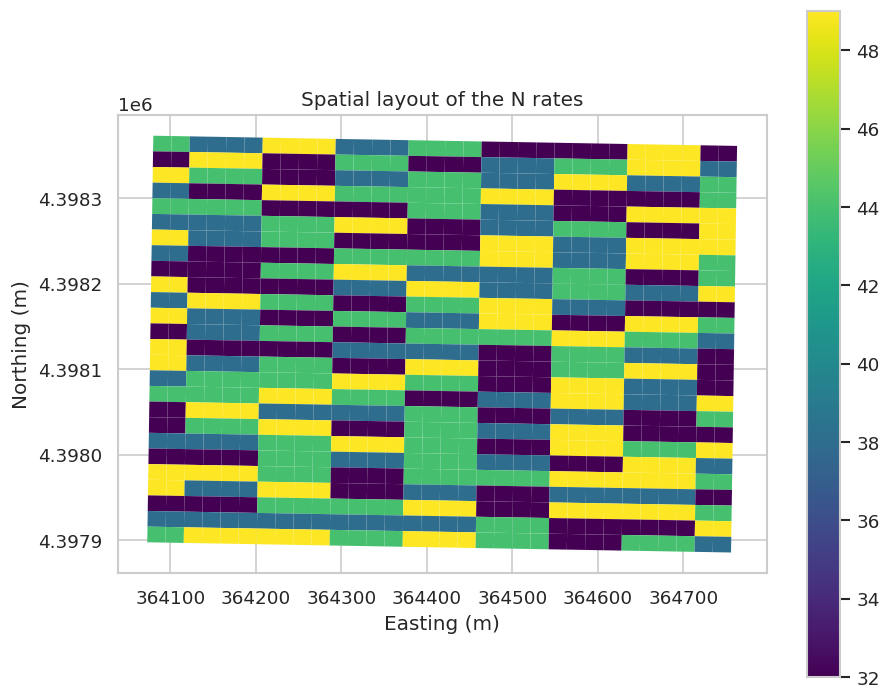

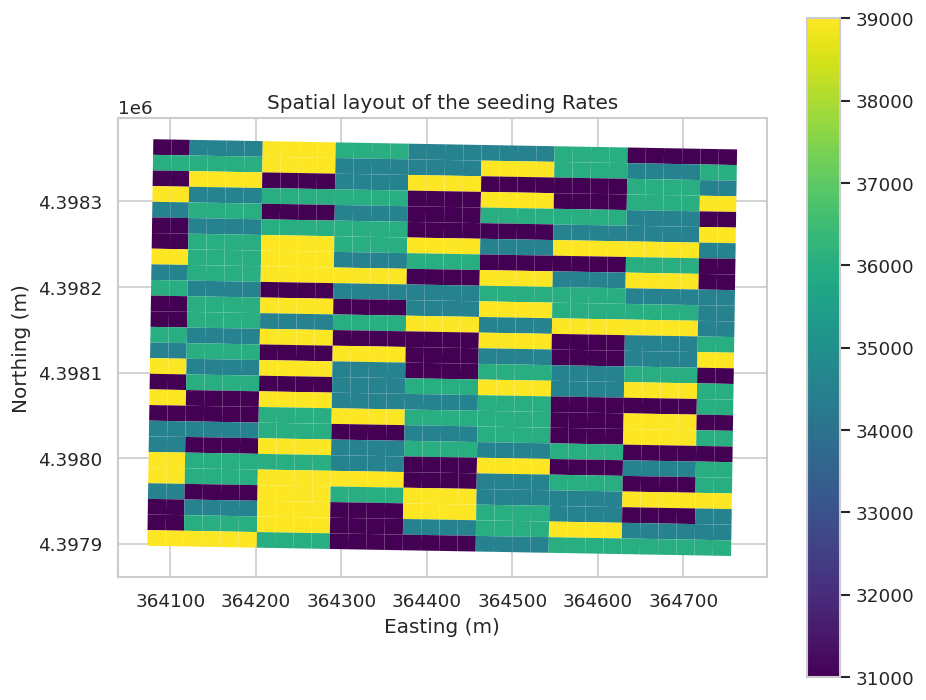

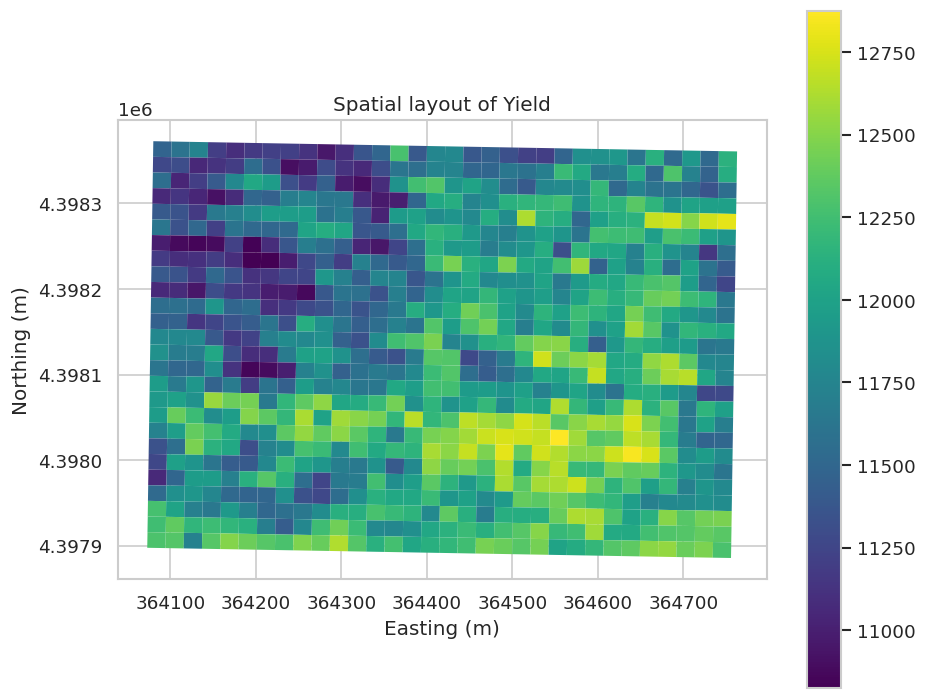

In [ ]:
# Spatial layout maps (NPlan, SRPlan, Yield)
# Helper to plot a choropleth with consistent style

def plot_choropleth(gdf, column, title, cmap="viridis"):
    ax = gdf.plot(column=column, cmap=cmap, edgecolor="none", legend=True)
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.tight_layout()
    plt.show()

plot_choropleth(field05, "NPlan", "Spatial layout of the N rates")
plot_choropleth(field05, "SRPlan", "Spatial layout of the seeding Rates")
plot_choropleth(field05, "Yield", "Spatial layout of Yield")


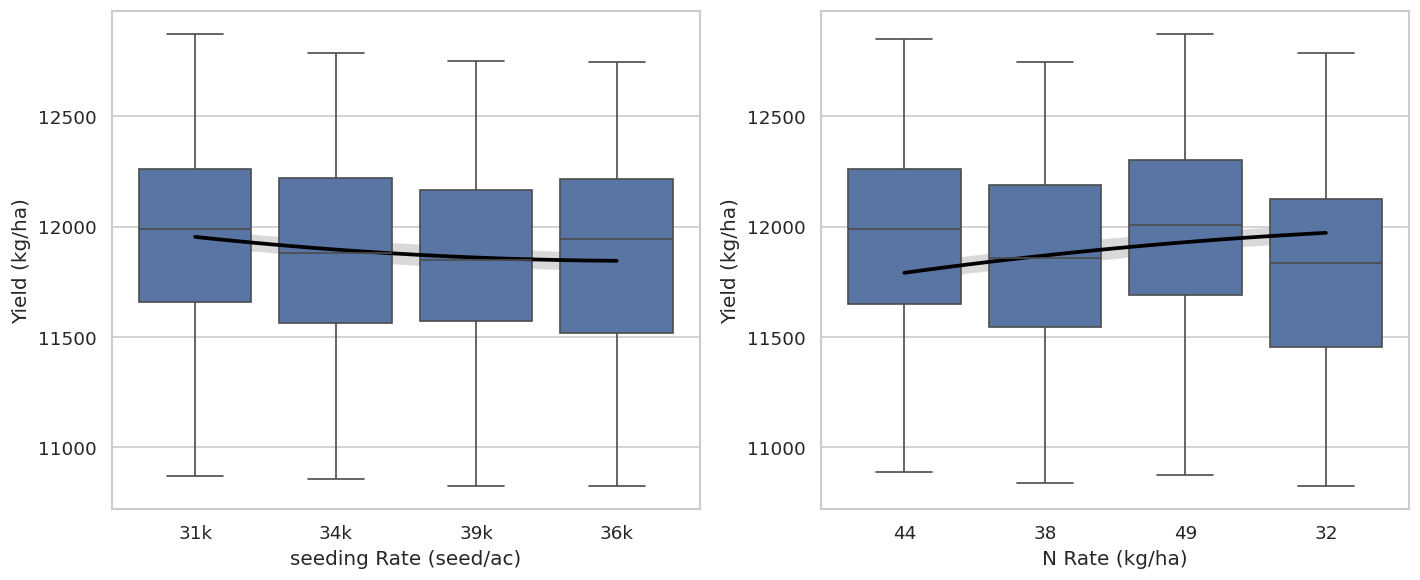

In [ ]:
# The overal yield response to seed and n rates is then summarized in the following boxplot charts.
# Boxplots: Yield vs SRPlanf and Yield vs NPlanf

if "SRPlanf" not in field05.columns:
    field05["SRPlanf"] = field05["SRPlan"].astype("category")
if "NPlanf" not in field05.columns:
    field05["NPlanf"] = field05["NPlan"].astype("category")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=field05, x="SRPlanf", y="Yield", ax=axes[0])
sns.regplot(x=field05['SRPlanf'].astype('category').cat.codes, y=field05['Yield'], order=2, scatter=False, ax=axes[0], color='black')
axes[0].set_xlabel("seeding Rate (seed/ac)")
axes[0].set_ylabel("Yield (kg/ha)")


sns.boxplot(data=field05, x="NPlanf", y="Yield", ax=axes[1])
sns.regplot(x=field05['NPlanf'].astype('category').cat.codes, y=field05['Yield'], order=2, scatter=False, ax=axes[1], color='black')
axes[1].set_xlabel("N Rate (kg/ha)")
axes[1].set_ylabel("Yield (kg/ha)")
plt.tight_layout()
plt.show()


As it is shown in the graphics above, the overal trend of yield against seeding rate and N are fairly linear with negative and positive slopes, respectively.

# Modelling

## Basic Linear Model
A starting point could be to fit a simple model with Yield as a function of SRPlan and NPlan:

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.60
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           7.63e-07
Time:                        14:30:45   Log-Likelihood:                -6237.9
No. Observations:                 832   AIC:                         1.248e+04
Df Residuals:                     828   BIC:                         1.250e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     9492.8423   1239.842      7.656   

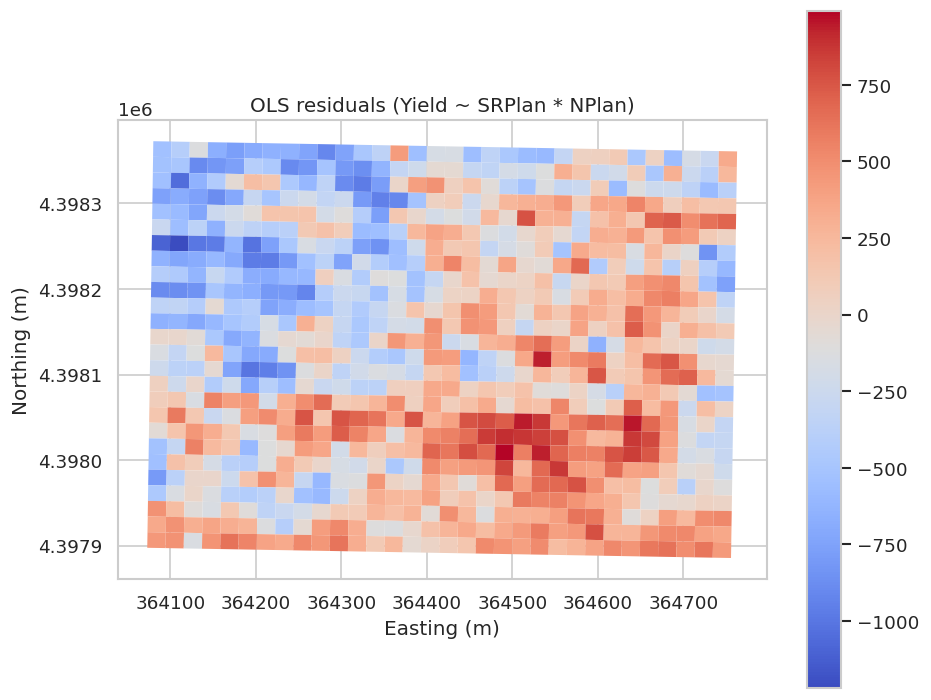

In [ ]:
# Basic linear model: Yield ~ SRPlan * NPlan
# Fit using statsmodels formula API, add residuals to GeoDataFrame
m_lm = ols("Yield ~ SRPlan * NPlan", data=field05).fit()
print(m_lm.summary())

field05["resid"] = m_lm.resid

# Plot residuals choropleth
plot_choropleth(field05, "resid", "OLS residuals (Yield ~ SRPlan * NPlan)", cmap="coolwarm")

R-squared = 0.037.
The model explains about 3.7% of the variation in yield.
That’s a low R², meaning most of the variation in yield is explained by other factors not included in this model.

F-statistic = 10.60 (p = 7.63e-07).
The overall model is statistically significant.
At least one predictor significantly explains variation in yield.

This model only explain 3% of total yield variation. In addition, this model does not take the autocorrelation into account and only estimate an overall function.

Autocorrelation can be checked computing the sample variogram of the residuals.

| Aspect                    | Meaning                                                                           |
| ------------------------- | --------------------------------------------------------------------------------- |
| **Model fit**             | Weak explanatory power (R² = 0.037).                                              |
| **Significant effects**   | NPlan (+) and SRPlan×NPlan (−) are significant.                                   |
| **Practical implication** | NPlan increases yield, but its benefit declines at higher SRPlan levels.          |
| **Cautions**              | Multicollinearity and autocorrelation are potential issues; residuals not normal. |



## Variogram

#### Why do we calculate a variogram?
When we run a regression, the model assumes that each observation is independent — meaning that the yield in one field or plot has nothing to do with the yield in the next one.
But in reality, spatial data often violate that assumption.

For example:
- Two neighboring plots might have similar soil quality, rainfall, or sunlight exposure.
- That means their yields — and their residuals (the model’s errors) — are spatially correlated.


So, the variogram helps us check whether the model residuals still show that kind of spatial relationship.
If the residuals are correlated over space, it means the model missed something spatial — maybe an environmental trend or unmeasured variable.

A variogram is a tool to measure how similar or different points are depending on how far apart they are.

- Take every pair of points (like two fields).
- Compute how far apart they are (distance).
- Compute how different their residuals are (difference in model error).
- Group all pairs by distance and calculate the average squared difference.
- Then plot this:
  - x-axis: distance between points
  - y-axis: average difference (variance of residuals)

A typical variogram curve rises and then flattens out — it looks like a hill that levels off.

| Part of curve                | What it means                      | In simple words                                                    |
| ---------------------------- | ---------------------------------- | ------------------------------------------------------------------ |
| **Low distance (left side)** | Small difference between residuals | Nearby locations behave similarly → spatial autocorrelation exists |
| **As distance increases**    | Differences grow                   | Further apart locations behave less alike                          |
| **Plateau (flat part)**      | Variance stops increasing          | Beyond a certain distance, points are independent                  |




#### Detrended variogram
When the residuals show a spatial trend (for example, higher yields toward one corner of the field), we can “remove” that trend by adding coordinates (x, y) or other spatial predictors like elevation to the model.


The detrended variogram checks whether that spatial structure disappears after accounting for spatial position.
If the variogram becomes flat after detrending, it means:
The remaining residuals are now independent.


`Nugget`: Nugget is what happens right at the start of the variogram - at distance =0/. The nugget shows the unexplained noise or very short range variation that the model can't capture.

`Sill`: It is the point where distance no longer matters - beyond sill, points are no more similar than any two random points.

`Partial Sill`: This represents the real spatial variation in the data. herefore, Total sill = Nugget + Partial Sill

`Range`: This is the distance over which locations influence each other. Beyond this distance, points are effecvely independent.

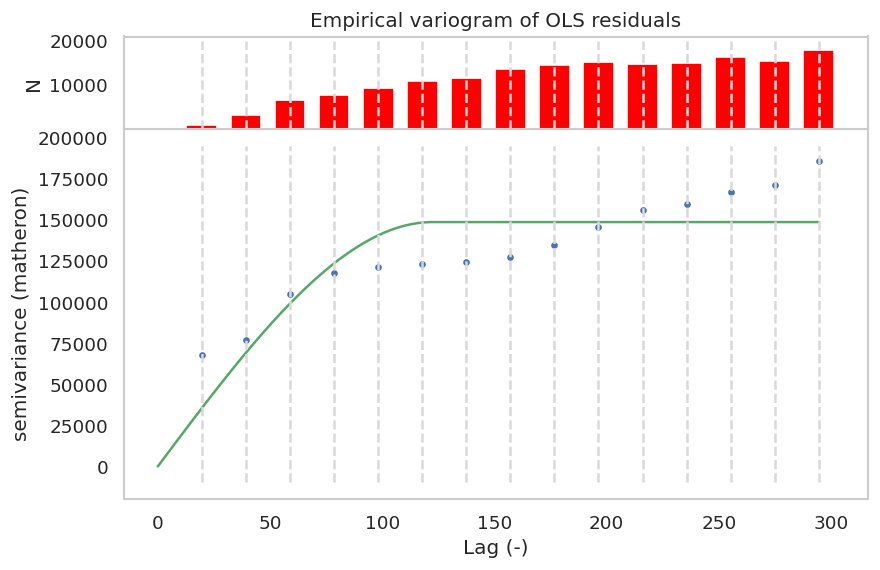

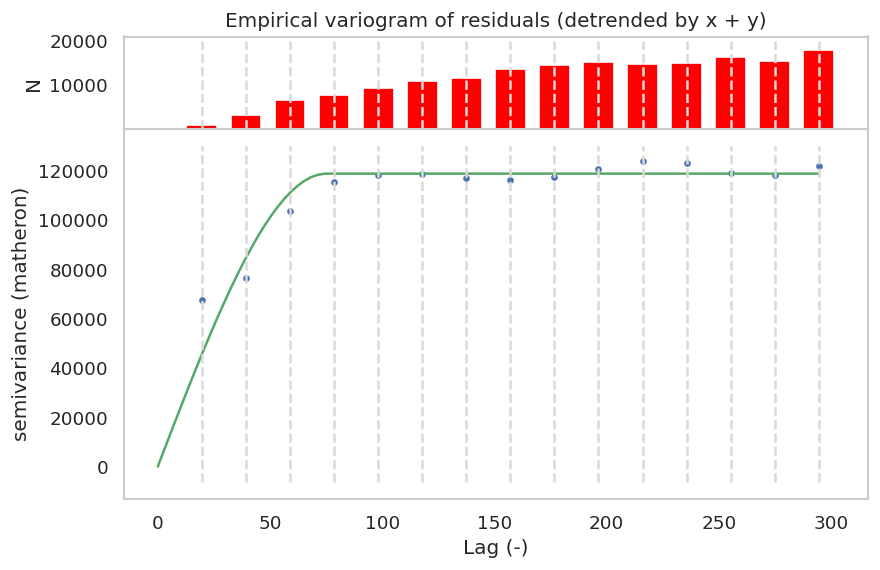

Trend R^2: 0.36411258371476474


In [ ]:
# Variogram of residuals and detrended variogram
# Extract point centroids for polygons for variogram calculations
centroids = field05.geometry.centroid
coords = np.vstack([centroids.x.values, centroids.y.values]).T
residuals = field05["resid"].values

# Empirical variogram
V = Variogram(coords, residuals, normalize=False, n_lags=15, maxlag="median")
fig = V.plot()
plt.title("Empirical variogram of OLS residuals")
plt.show()

# Detrending using linear coordinates (x, y)
X_trend = sm.add_constant(pd.DataFrame({"x": coords[:,0], "y": coords[:,1]}))
trend_model = sm.OLS(residuals, X_trend).fit()
resid_detrended = residuals - trend_model.predict(X_trend)

V_detrended = Variogram(coords, resid_detrended, normalize=False, n_lags=15, maxlag="median")
fig = V_detrended.plot()
plt.title("Empirical variogram of residuals (detrended by x + y)")
plt.show()

print("Trend R^2:", trend_model.rsquared)


## GWR Model

The GWR procedure allows the estimation of spatially variable functions within a certain spatial domain.





### Seeding Rate

Selected bandwidth (neighbors): 48.0
Model type                                                         Gaussian
Number of observations:                                                 832
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       163045586.407
Log-likelihood:                                                   -6249.811
AIC:                                                              12503.623
AICc:                                                             12505.652
BIC:                                                           163040005.626
R2:                                                                   0.009
Adj. R2:                                                              0.008

Variable                              Est.         SE  t(Est/SE)    p-value
---------------------

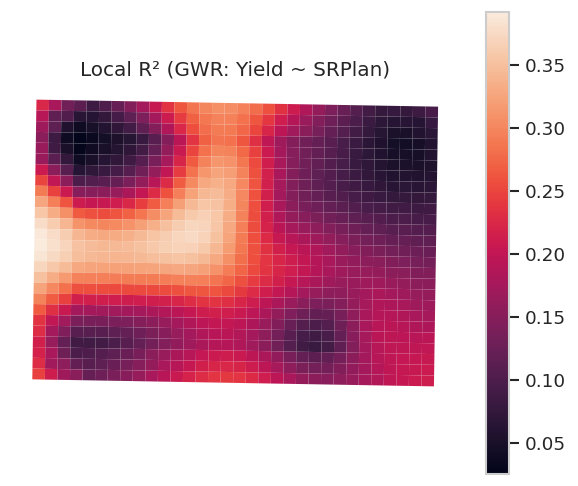

In [ ]:
# GWR
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# GWR: Yield ~ SRPlan (adaptive bandwidth)
# Prepare coordinates (u, v) and design matrix
centroids = field05.geometry.centroid
u = centroids.x.values.reshape((-1, 1))
v = centroids.y.values.reshape((-1, 1))
coords_gwr = np.hstack([u, v])

# Response and predictor
y = field05[["Yield"]].values.astype(float)
X = field05[["SRPlan"]].values.astype(float)
X = sm.add_constant(X, has_constant='add')  # [Intercept, SRPlan]

# (Optional) standardize for numerical stability; not required, but harmless
#X[:, 1] = (X[:, 1] - X[:, 1].mean()) / (X[:, 1].std() + 1e-9)
#y = (y - y.mean()) / (y.std() + 1e-9)

# Bandwidth selection (adaptive kNN)
selector = Sel_BW(coords_gwr, y, X, fixed=False)  # adaptive
try:
    bw = selector.search()  # data-driven optimum
except Exception:
    print("Fallback to fixed bandwidth")
    selector = Sel_BW(coords_gwr, y, X, fixed=True)
    bw = selector.search()

# adapt --> controls the amount of neighbours (k-nearest neighbours) included in the estimation of te local function.
# the smaller value, the more local the function is, nd possibly as estimated with fewer values.
# In the below line, only 5% of the neigbours are included.
# k05 = max(20, int(round(0.05 * X.shape[0])))  # ~5% neighbors, min guard
# bw = k05

print("Selected bandwidth (neighbors):", bw)

# Fit GWR (Gaussian kernel, adaptive)
model = GWR(coords_gwr, y, X, bw=bw, fixed=False, kernel='gaussian') # remove kernel='gaussian' and see how results change!
res = model.fit()
print(res.summary())  # concise model summary

# --- Build a quick coefficient summary at data points

betas = res.params  # columns: [Intercept, SRPlan]
summary = pd.DataFrame({
    'Min.':      betas.min(axis=0),
    '1st Qu.':   np.quantile(betas, 0.25, axis=0),
    'Median':    np.quantile(betas, 0.50, axis=0),
    '3rd Qu.':   np.quantile(betas, 0.75, axis=0),
    'Max.':      betas.max(axis=0),
}, index=['X.Intercept.', 'SRPlan'])
print("\nSummary of GWR coefficient estimates at data points:")
print(summary.round(6))

# --- Add outputs back to GeoDataFrame (for mapping/export)
field05 = field05.copy()
field05['Intercept']   = betas[:, 0]
field05['SRPlan_coef'] = betas[:, 1]
field05['predicted']   = res.predy.flatten()
field05['residual']    = (y.flatten() - res.predy.flatten())
field05['localR2']     = res.localR2

# ---  plot localR2 - OR - Intercept, SRPlan_coef, predicted, residual, localR2
ax = field05.plot(column='localR2', legend=True, edgecolor='none', figsize=(6,5))
ax.set_title("Local R² (GWR: Yield ~ SRPlan)")
ax.set_axis_off()
plt.show()



### N Rate

Selected bandwidth (neighbors): 48.0
Model type                                                         Gaussian
Number of observations:                                                 832
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       160638000.843
Log-likelihood:                                                   -6243.623
AIC:                                                              12491.246
AICc:                                                             12493.275
BIC:                                                           160632420.062
R2:                                                                   0.024
Adj. R2:                                                              0.023

Variable                              Est.         SE  t(Est/SE)    p-value
---------------------

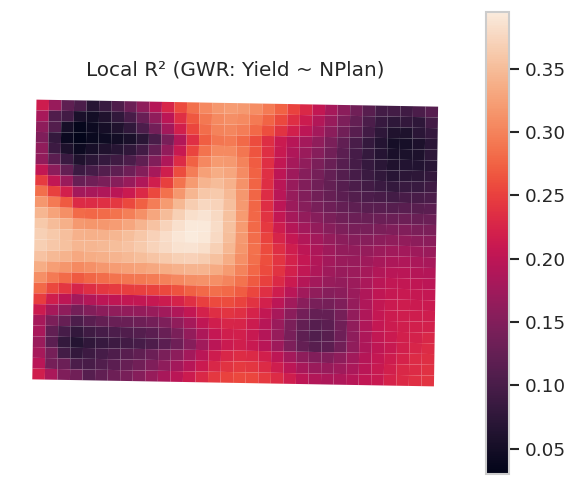

In [ ]:
# GWR: Yield ~ NPlan (adaptive bandwidth)
# Prepare coordinates (u, v) and design matrix
centroids = field05.geometry.centroid
u = centroids.x.values.reshape((-1, 1))
v = centroids.y.values.reshape((-1, 1))
coords_gwr = np.hstack([u, v])

# Response and predictor
y = field05[["Yield"]].values.astype(float)
X = field05[["NPlan"]].values.astype(float)
X = sm.add_constant(X, has_constant='add')  # [Intercept, NPlan]

# (Optional) standardize for numerical stability; to match R keep raw units
# X[:, 1] = (X[:, 1] - X[:, 1].mean()) / (X[:, 1].std() + 1e-9)
# y       = (y - y.mean()) / (y.std() + 1e-9)

# Bandwidth selection (adaptive kNN)
selector = Sel_BW(coords_gwr, y, X, fixed=False)  # adaptive k-NN
try:
    bw = selector.search()  # data-driven optimum (typically AICc/CV)
except Exception:
    print("Fallback to fixed bandwidth")
    selector = Sel_BW(coords_gwr, y, X, fixed=True)
    bw = selector.search()

# adapt --> controls the amount of neighbours (k-nearest neighbours) included in the local fit.
# smaller adapt => more local models with fewer neighbors.
# To mirror R's adapt = 0.05 exactly (≈ 41 of 832), uncomment the next two lines:
# k05 = max(20, int(round(0.05 * X.shape[0])))  # ~5% neighbors, with a small safety floor
# bw = k05

print("Selected bandwidth (neighbors):", bw)

# Fit GWR (Gaussian kernel, adaptive) — Gaussian to match R's spgwr default in your guide
model = GWR(coords_gwr, y, X, bw=bw, fixed=False, kernel='gaussian')  # try removing kernel='gaussian' to see differences
res = model.fit()
print(res.summary())  # concise model summary

# --- Build a quick coefficient summary at data points
betas = res.params  # columns: [Intercept, NPlan]
summary = pd.DataFrame({
    'Min.':      betas.min(axis=0),
    '1st Qu.':   np.quantile(betas, 0.25, axis=0),
    'Median':    np.quantile(betas, 0.50, axis=0),
    '3rd Qu.':   np.quantile(betas, 0.75, axis=0),
    'Max.':      betas.max(axis=0),
}, index=['X.Intercept.', 'NPlan'])
print("\nSummary of GWR coefficient estimates at data points:")
print(summary.round(6))

# --- Add outputs back to GeoDataFrame (for mapping/export)
field05 = field05.copy()
field05['Intercept']   = betas[:, 0]
field05['NPlan_coef']  = betas[:, 1]
field05['predicted']   = res.predy.flatten()
field05['residual']    = (y.flatten() - res.predy.flatten())
field05['localR2']     = res.localR2

# --- Plot localR2 (or map 'Intercept', 'NPlan_coef', 'predicted', 'residual', 'localR2')
ax = field05.plot(column='localR2', legend=True, edgecolor='none', figsize=(6,5))
ax.set_title("Local R² (GWR: Yield ~ NPlan)")
ax.set_axis_off()
plt.show()